# Units mystery in the Priestley-Taylor equation <a class="tocSkip">

Author: Stan Schymanski, stan.schymanski@datascience.ch

In this worksheet, we explore the famous Priestley-Taylor equation (Priestley and Taylor, 1972) using the Environmental Science for Symbolic Math (essm) package, downloadable from https://github.com/environmentalscience/essm. Note that this notebook is compatible with v0.2.0 of essm.

In [1]:
# setting some general options for the notebook
from IPython.display import HTML, display
from sympy import diff, init_printing
init_printing(use_latex='mathjax')  # This causes mathjax to render all output
from sympy.printing import StrPrinter
StrPrinter._print_Quantity = lambda self, expr: str(expr.abbrev)    # displays short units (m instead of meter)

In [2]:
# importing relevant functions from sympy and essm
from sympy.physics.units import convert_to
from sympy import diff, Derivative
from essm import Eq, e
from essm.equations import Equation
from essm.variables import Variable
from essm.variables.utils import generate_metadata_table
from essm.variables.units import derive_unit, derive_baseunit, markdown, SI
from essm.variables.units import joule, kelvin, kilogram, meter, pascal, second, watt

# Derivation of PT equation

Below, we use essm `Variable` class to define relevant variables used in the paper by Priestley and Taylor. Since units were not provided in the paper, we assume standard SI units for each variable. Since $q_s$ was referred to as specific humidity at saturation by Priestley and Taylor (1972), we assume units of kg m$^{-3}$. Consequently, since $s=\partial q_s/\partial T$, the units of $s$ are assumed to be kg m$^{-3}$ K$^{-1}$.

In [3]:
class E_w(Variable):
    """Wet surface evaporation
    (E in Priestley and Taylor, 1972))
    """
    unit = kilogram/meter**2/second
    latex_name = 'E'
    
class H_w(Variable):
    """Wet surface sensible heat flux (positive outwards)"""
    unit = watt/meter**2
    latex_name = 'H'
      
class q_a(Variable):
    """Specific humidity"""
    unit = kilogram/meter**3
    
class q_s(Variable):
    """Specific humidity at saturation"""
    unit = kilogram/meter**3
    
class T(Variable):
    """Temperature"""
    unit = kelvin
    
class s_PT(Variable):
    """Priestley-Taylor $\partial q_s/\partial T$"""
    #unit = kilogram/meter**3/kelvin
    expr = Derivative(q_s, T)
    latex_name = 's'

We will import latent heat of evaporation and specific heat of dry air from the essm thermodynamics library and define $\gamma = c_{pa}/L:

In [4]:
from essm.variables.physics.thermodynamics import lambda_E, c_pa
class gamma_PT(Variable):
    """Priestley-Taylor gamma = c_p/L"""
    latex_name = r"\gamma"
    expr = c_pa/lambda_E
gamma_PT.definition.unit    

1
─
K

We will re-define `lambda_E` as `L_E` to have the same latex representation as in the paper, and we also define $L \times E$ as separate variable, $LE$:

In [5]:
class L_E(lambda_E.definition):
    """Latent heat"""
    
    latex_name = 'L'
    default = lambda_E.definition.default
    unit = lambda_E.definition.unit

class LE(Variable):
    """Latent heat flux from wet surface"""
    expr = L_E * E_w
    unit = watt / meter ** 2
LE.definition.unit
    

W 
──
 2
m 

In [6]:
generate_metadata_table([E_w, H_w, L_E, c_pa, q_s, s_PT, gamma_PT])

Symbol,Name,Description,Default value,Units
$\gamma$,gamma_PT,Priestley-Taylor gamma = c_p/L,-,K$^{-1}$
$c_{pa}$,c_pa,Specific heat of dry air.,1010.0,J K$^{-1}$ kg$^{-1}$
$E$,E_w,"Wet surface evaporation (E in Priestley and Taylor, 1972))",-,kg m$^{-2}$ s$^{-1}$
$H$,H_w,Wet surface sensible heat flux (positive outwards),-,W m$^{-2}$
$L$,L_E,Latent heat,2450000.0,J kg$^{-1}$
$q_s$,q_s,Specific humidity at saturation,-,kg m$^{-3}$
$s$,s_PT,Priestley-Taylor $\partial q_s/\partial T$,-,K$^{-1}$ kg m$^{-3}$


## Eq. 3

Eq. 3 was given in the paper as:
$$ \frac{LE}{H} = \frac{L}{c_p} s = \frac{s}{\gamma} $$

Now, we will try to define Eq. 3 in the paper as a physical equation, using essm's `Equation` class:

In [7]:
eq3 = Eq(L_E*E_w/H_w, L_E/c_pa*s_PT)
display(eq3)
try: 
    class eq_3(Equation):
        """Equation 3 in Priestley and Taylor (1972)"""
        expr = eq3
except Exception as error:
    print(error)

E_w⋅L_E   L_E⋅s_PT
─────── = ────────
  H_w       c_pa  

summation of quantities of incompatible dimensions


**Our attempt failed because of dimensional inconsistency!**

Since $EL/H$ is non-dimensional, the right hand side of Eq. 3 must be non-dimensioanl, too. Clearly, the units of Eq. 3 do not match if we use our assumptions about the units of $L$, $s$ and $c_{pa}$. Either the equation is missing a division by a density term (units of kg m$^{-3}$) on the right hand side, or one of our assumptions about the units involved was different to what the authors had in mind. 

In [8]:
derive_baseunit(eq3.rhs)

kg
──
 3
m 

In [9]:
derive_baseunit(eq3.lhs)

1

## Eq. 7a
In Eq. 7a, Priestley and Taylor reproduce the Penman equation:
$$LE = \frac{s}{s+\gamma} (R-G) + \frac{\gamma}{s + \gamma} h(q_s - q)$$

We will check whether the representation here has matching units, using the definition of variables given in the text. Note that $\gamma$ was defined below Eq. 3 in the original paper as $\gamma = c_p/L$.
Therefore, the units of $\gamma$ should be: 

In [10]:
derive_unit(c_pa/L_E)

1
─
K

In [11]:
class R(Variable):
    """Net incoming radiation."""
    unit = watt/meter**2

class G(Variable):
    """Heat flux into the ground."""
    unit = watt/meter**2

The meaning of $h$ was described as "a suitably defined transfer coefficient", so its units can be adjusted to achieve consistent dimensions. To find out what the appropriate units for $h$ should be, we will define a symbol h with undefined units and then solve Eq. 7a for h to get its units:

In [12]:
from sympy import Symbol, solve
h = Symbol('h')
eq7a = Eq(LE, s_PT/(s_PT + gamma_PT) * (R - G) +
                gamma_PT/(s_PT + gamma_PT) * h *(q_s - q_a))
eq7a.simplify()

     -(γ_PT⋅h⋅(qₐ - q_s) + s_PT⋅(G - R)) 
LE = ────────────────────────────────────
                 γ_PT + s_PT             

We will now check if the units of the right hand side match the units of $LE$:

In [13]:
try: 
    print(derive_baseunit(eq7a.rhs))
except Exception as e1:
    print(e1)

summation of quantities of incompatible dimensions


The term $s + \gamma$ in the denominator implies that $s$ and $\gamma$ must have the same units, but: 

In [14]:
generate_metadata_table([s_PT, gamma_PT])

Symbol,Name,Description,Default value,Units
$\gamma$,gamma_PT,Priestley-Taylor gamma = c_p/L,-,K$^{-1}$
$s$,s_PT,Priestley-Taylor $\partial q_s/\partial T$,-,K$^{-1}$ kg m$^{-3}$


Again, the units differ by a density term (kg m$^{-3}$).

# Comparison with Penman (1948)
Penman (1948) actually worked with vapour pressure, not specific humidity, such that the slope of the vapour saturation curve at air temperature ($\Delta_{e}$) had units of Pa/K.

In [15]:
class Delta_eTa(Variable):
    """Slope of saturation vapour pressure at air temperature"""
    latex_name = r"\Delta"
    unit = pascal/kelvin

According to Eq. 10 in Penman (1948), $\gamma = \beta \frac{e_s - e_d}{T_s - T_a}$ i.e. has dimensions of pressure devided by temperature, similar to $\Delta$:

In [16]:
class beta(Variable):
    """Bowen ratio, LE/H"""
    expr = LE/H_w
    
class e_s(Variable):
    """
    Saturation vapour pressure at dew point, 
    i.e. actual vapour pressure
    """
    unit = pascal
    
class e_a(Variable):
    """Saturation vapour pressure at air temperature"""
    unit = pascal
    
class e_d(Variable):
    """Saturation vapour pressure at dew point"""
    unit = pascal
    
class T_a(Variable):
    """Air temperature"""
    unit = kelvin
    
class T_s(Variable):
    """Surface temperature"""
    unit = kelvin    
    
class gamma_P(Variable):
    """Penman gamma, gamma = beta(e_s - e_d)/(T_s - T_a)"""
    expr = beta * (e_s - e_d) / (T_s - T_a)
    latex_name = r"\gamma_P"
    #unit = pascal/kelvin

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.physics.thermodynamics:T_a" will be overridden by "__main__:<class '__main__.T_a'>"
  instance[expr] = instance


With these definitions, Priestley and Taylor's reproduction of the Penman equation in Eq. 7a would be dimensionally consistent:
$$LE = \frac{\Delta}{\Delta+\gamma} (R-G) + \frac{\gamma}{\Delta + \gamma} h(q_s - q)$$

In [17]:
eq7aP = eq7a.subs({s_PT: Delta_eTa, gamma_PT: gamma_P})
display(eq7aP)
print derive_baseunit(eq7aP.lhs)
print(derive_baseunit(eq7aP.rhs))

     Δ_eTa⋅(-G + R)   γ_P⋅h⋅(-qₐ + q_s)
LE = ────────────── + ─────────────────
      Δ_eTa + γ_P        Δ_eTa + γ_P   

kg/s**3
kg/s**3


We will now solve the equation for h to find out what the units should be:

In [18]:
soln = solve(eq7aP, h, dict=True)
soln

⎡⎧   -Δ_eTa⋅G - Δ_eTa⋅LE + Δ_eTa⋅R - LE⋅γ_P⎫⎤
⎢⎨h: ──────────────────────────────────────⎬⎥
⎣⎩               γ_P⋅(qₐ - q_s)            ⎭⎦

In [19]:
derive_baseunit(soln[0][h])

 3
m 
──
 3
s 

The units of h should be m$^3$ s$^{-3}$ to make the equation dimensionally consistent. So now we can define h in this way and write Eq. 7a in Priestley and Taylor using Penman's variable definitions:

In [20]:
class h_PT(Variable):
    """Priestley-Taylor transfer coefficient"""
    latex_name = r"h"
    unit = meter ** 3 / second ** 3

class eq_7aP(Equation):
    """Eq. 7a in Priestley-Taylor using Penman variables"""
    expr = eq7aP.subs(h, h_PT)
eq_7aP

     Δ_eTa⋅(-G + R)   γ_P⋅h_PT⋅(-qₐ + q_s)
LE = ────────────── + ────────────────────
      Δ_eTa + γ_P         Δ_eTa + γ_P     

In comparison, Penman's original equation (Eq. 16) was: 
$$LE = \frac{(R - G)  \Delta + \gamma_P (e_a - e_d)  f_u}{\Delta + \gamma_P}$$
As Priestley and Taylor, Penman did not provide the units of $f_u$, so we will first define it as a unitless symbol and then derive appropriate units to make the equation dimensionally consistent:

In [21]:
class e_a(Variable):
    """Saturation vapour pressure at air temperature"""
    unit = pascal
    
class e_d(Variable):
    """Saturation vapour pressure at dew point"""
    unit = pascal
    
f_u = Symbol('f_u')
eq16P =  Eq(LE, ((R - G) * Delta_eTa + gamma_P * (e_a - e_d) * f_u) /
            (Delta_eTa + gamma_P))
eq16P

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "__main__:e_a" will be overridden by "__main__:<class '__main__.e_a'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "__main__:e_d" will be overridden by "__main__:<class '__main__.e_d'>"
  instance[expr] = instance


     Δ_eTa⋅(-G + R) + γ_P⋅fᵤ⋅(eₐ - e_d)
LE = ──────────────────────────────────
                Δ_eTa + γ_P            

In [22]:
soln = solve([eq16P], f_u)
soln

⎧    Δ_eTa⋅G + Δ_eTa⋅LE - Δ_eTa⋅R + LE⋅γ_P⎫
⎨fᵤ: ─────────────────────────────────────⎬
⎩                γ_P⋅(eₐ - e_d)           ⎭

In [23]:
derive_baseunit(soln[f_u])

m
─
s

The correct units of f_u are m/s.

In [24]:
class f_u(Variable):
    """Wind function in Penman approach, f(u) adapted to energetic units"""
    unit = meter/second  

class eq_16(Equation):
    """Penman equation for latent heat flux"""
    expr = Eq(LE, ((R - G) * Delta_eTa + gamma_P * (e_a - e_d) * f_u) /
            (Delta_eTa + gamma_P))
    
eq_16

     Δ_eTa⋅(-G + R) + fᵤ⋅γ_P⋅(eₐ - e_d)
LE = ──────────────────────────────────
                Δ_eTa + γ_P            

This shows that with the above definitions of variables, Eq. 7a in Priestley & Taylor (1972) is consistent with Eq. 16 in Penman (1948), except that P&T used specific humidity, whereas P used vapour pressure as driver for the aerodynamic part.

# Coming back to the PT-Equation
With Penman's variables, Eq. 3 in Priestley&Taylor is still not dimensionally consistent, but if we replace both $s$ by $\Delta$ and the PT definition of $\gamma$ by that of Penman (1948), the second part does become dimensionally consistent:

In [25]:
display(eq3.subs(s_PT, Delta_eTa))
display(derive_baseunit(eq3.subs(s_PT, Delta_eTa).rhs))
eq3_P = Eq(eq3.lhs, s_PT/gamma_PT).subs({s_PT: Delta_eTa, gamma_PT: gamma_P})
display(eq3_P)
derive_baseunit(eq3_P.rhs)

E_w⋅L_E   Δ_eTa⋅L_E
─────── = ─────────
  H_w        c_pa  

 kg 
────
   2
m⋅s 

E_w⋅L_E   Δ_eTa
─────── = ─────
  H_w      γ_P 

1

**It is still not clear how the first part of Eq. 3 can be made dimensionally consistent!**

The Priestley-Taylor coefficient $\alpha$ is introduced in Eq. 5. The authors never mention the units of $\alpha$, so we will derive the correct units below.

In [26]:
alpha = Symbol('alpha')
eq5 = Eq(LE / (LE + H_w), alpha * s_PT/(s_PT + gamma_PT))
display(eq5)
try: derive_baseunit(eq5.rhs)
except Exception as e1: print(e1)

   LE         s_PT⋅α  
──────── = ───────────
H_w + LE   γ_PT + s_PT

summation of quantities of incompatible dimensions


**Again the units don't match, which is because the units of $\gamma$ and $s$ should be the same, but they are not:**

In [27]:
generate_metadata_table([s_PT, gamma_PT])

Symbol,Name,Description,Default value,Units
$\gamma$,gamma_PT,Priestley-Taylor gamma = c_p/L,-,K$^{-1}$
$s$,s_PT,Priestley-Taylor $\partial q_s/\partial T$,-,K$^{-1}$ kg m$^{-3}$


Now we will use Penman's variables instead:

In [28]:
generate_metadata_table([Delta_eTa, gamma_P])

Symbol,Name,Description,Default value,Units
$\Delta$,Delta_eTa,Slope of saturation vapour pressure at air temperature,-,K$^{-1}$ Pa
$\gamma_P$,gamma_P,"Penman gamma, gamma = beta(e_s - e_d)/(T_s - T_a)",-,K$^{-1}$ Pa


In [29]:
eq5P = eq5.subs({s_PT: Delta_eTa, gamma_PT: gamma_P})
display(eq5P)
derive_unit(eq5P.rhs)

   LE        Δ_eTa⋅α  
──────── = ───────────
H_w + LE   Δ_eTa + γ_P

1

With Penman's variables, the PT equation actually becomes dimensionally consistent and $\alpha$ becomes non-dimensional:

In [30]:
class alpha_P(Variable):
    """PT alpha parameter for equation based on Penman's variables."""
    unit = 1/1
    latex_name = r"\alpha"

class eq_5P(Equation):
    """Eq. 5 in Priestley & Taylor (1972) using Penman's variable definitions."""
    expr = eq5P.subs(alpha, alpha_P)    
eq_5P

   LE       Δ_eTa⋅α_P 
──────── = ───────────
H_w + LE   Δ_eTa + γ_P

Now, Eq. 5 is not very useful, as it still requires knowledge of $H_w$. What we usually refer to as the PT equation, is Eq. 8 in Priestley & Taylor (1972), after solving for $L E$. Note that Eq. 8 is deduced from Eq. 5 by substituting $R - G$ for $LE + H$ and solving for $\alpha$. We will re-derive Eq. 8 using Penman variables for dimensional consistency:

In [31]:
class eq_enbalance(Equation):
    """Surface energy balance."""
    expr = Eq(R - G, LE + H_w)
eq_enbalance

-G + R = H_w + LE

In [32]:
class eq_8P(eq_enbalance.definition, eq_5P.definition):
    """Eq. 8 in Priestley & Taylor (1972) using Penman's variable definitions."""
    soln = solve([eq_5P.lhs.subs(eq_enbalance.rhs, eq_enbalance.lhs) 
              - eq_5P.rhs], LE)
    expr = Eq(LE, soln[LE])    
eq_8P

     Δ_eTa⋅α_P⋅(-G + R)
LE = ──────────────────
        Δ_eTa + γ_P    

For $\alpha_P=1$, it is actually equivalent to the Penman equation if $f(u)=0$:

In [33]:
eq_16.subs({f_u: 0})

     Δ_eTa⋅(-G + R)
LE = ──────────────
      Δ_eTa + γ_P  

In [34]:
eq_8P.subs({alpha_P: 1})

     Δ_eTa⋅(-G + R)
LE = ──────────────
      Δ_eTa + γ_P  

# Some plots
Before we can generate any plottable data, we need to know what variables need to be computed/provided. For this purpose we will import a function (extract_variables) from essm that lists all free variables in an expression:

In [35]:
from essm.variables.utils import extract_variables

For convenience, we will create a dictionary with all default values defined for the different variables:

In [36]:
# Copy default values into cdict:
cdict = Variable.__defaults__.copy()

Now we can substitute all default values into the equation we want to plot and then use `extract_variables` to list the remaining unknowns:

In [37]:
extract_variables(eq_8P.subs(cdict))


{Δ_eTa, G, LE, R, α_P, γ_P}

So to calculate $E$ using eq_8P, we can prescribe $R$, $G$, and $\alpha$ (=1.26 according to the paper), but we still need to provide equations for $\Delta_e$ and $\gamma$. For the former, we will use Eq. B5 in Schymanski et al. (2017) 

In [38]:
from essm.variables.physics.thermodynamics import M_w, R_mol
    
class T_a(Variable):
    """Air temperature"""
    unit = kelvin


class eq_ea(Equation):
    """Clausius-Clapeyron saturation vapour pressure as function of T_a.

    (Eq. B3 in :cite:`hartmann_global_1994`)
    """

    class p_CC1(Variable):
        """Internal parameter of eq_Pwl."""

        name = 'p_CC1'
        unit = pascal
        domain = 'real'
        latex_name = 'p_1'
        default = 611.

    class p_CC2(Variable):
        """Internal parameter of eq_Pwl."""

        name = 'p_CC2'
        unit = kelvin
        domain = 'real'
        latex_name = 'p_2'
        default = 273.

    expr = Eq(
        e_a, p_CC1 * e ** (-M_w * L_E * (1 / T_a - 1 / p_CC2) / R_mol))

eq_ea

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "__main__:T_a" will be overridden by "__main__:<class '__main__.T_a'>"
  instance[expr] = instance


                     ⎛    1     1 ⎞ 
            -L_E⋅M_w⋅⎜- ───── + ──⎟ 
                     ⎝  p_CC2   Tₐ⎠ 
            ────────────────────────
                     R_mol          
eₐ = p_CC1⋅ℯ                        

We will now differentiate with respect to $T_a$, in order to define $\Delta$:

In [39]:
class eq_Delta_eTa(eq_ea.definition):
    """de_a/dT_a"""
    expr = Eq(Delta_eTa, diff(eq_ea.rhs, T_a))
    
eq_Delta_eTa

                                ⎛    1     1 ⎞ 
                       -L_E⋅M_w⋅⎜- ───── + ──⎟ 
                                ⎝  p_CC2   Tₐ⎠ 
                       ────────────────────────
                                R_mol          
        L_E⋅M_w⋅p_CC1⋅ℯ                        
Δ_eTa = ───────────────────────────────────────
                               2               
                       R_mol⋅Tₐ                

For $\gamma$, we will use the definition provided by Monteith & Unsworth (2013): 
$$\gamma = \frac{c_p P}{0.622 L}$$

In [40]:
class P_a(Variable):
    """Air pressure"""
    unit = pascal
    
class eq_gamma(Equation):
    """Psychrometric constant as defined by Monteith and Unsworth (2013)"""
    
    class p_eps(Variable):
        """Internal parameter of eq_gamma."""

        unit = 1/1
        domain = 'real'
        latex_name = r"\epsilon"
        default = 0.622
    
    expr = Eq(gamma_P, c_pa * P_a / (p_eps * L_E))
    
eq_gamma

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.physics.thermodynamics:P_a" will be overridden by "__main__:<class '__main__.P_a'>"
  instance[expr] = instance


       Pₐ⋅c_pa 
γ_P = ─────────
      L_E⋅p_eps

Now, we will define a function to help us plotting the values of an expression:

In [41]:
import matplotlib.pyplot as plt
from sympy import latex
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown
def plot_expr(expr, xvar, yvar, xmin, xmax, clf=True):
    '''Plot expression as function for variable from xmin to xmax.'''
    
    if clf:
        plt.close
        plt.clf
    xstep = (xmax - xmin)/100
    xvals = arange(xmin, xmax, xstep)
    yvals = [expr.subs(xvar, dummy) for dummy in xvals]
    try:
        plt.plot(xvals, yvals)
        plt.xlabel('$'+latex(xvar)+'$' + ' (' + markdown(xvar.definition.unit) + ')')
        plt.ylabel('$'+latex(yvar)+'$' + ' (' + markdown(yvar.definition.unit) + ')')
        plt.show()
    except Exception as e1:
        print yvals
        print e1

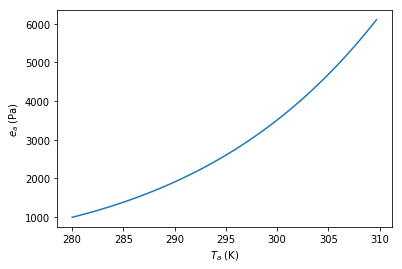

In [42]:
# Plotting the saturation vapour pressure curve
cdict = Variable.__defaults__.copy()    
plot_expr(eq_ea.rhs.subs(cdict), T_a, e_a, 280., 310., clf=True)

Now, we will plot eq_8P as a function of air temperature, by substituting eq_Delta_eTa and eq_gamma into eq_8P:

In [43]:
display(eq_8P)
display(eq_Delta_eTa)
display(eq_gamma)
extract_variables(eq_8P.subs({Delta_eTa: eq_Delta_eTa.rhs, gamma_P: eq_gamma.rhs}).subs(cdict))

     Δ_eTa⋅α_P⋅(-G + R)
LE = ──────────────────
        Δ_eTa + γ_P    

                                ⎛    1     1 ⎞ 
                       -L_E⋅M_w⋅⎜- ───── + ──⎟ 
                                ⎝  p_CC2   Tₐ⎠ 
                       ────────────────────────
                                R_mol          
        L_E⋅M_w⋅p_CC1⋅ℯ                        
Δ_eTa = ───────────────────────────────────────
                               2               
                       R_mol⋅Tₐ                

       Pₐ⋅c_pa 
γ_P = ─────────
      L_E⋅p_eps

{G, LE, Pₐ, R, Tₐ, α_P}

So we need to prescribe $G$, $P_a$, $R$, $T_a$ and $\alpha$ to plot LE using eq_8P.

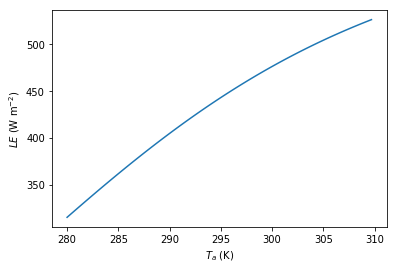

In [44]:
vdict = cdict.copy()
vdict[G] = 0
vdict[R] = 500
vdict[P_a] = 101325
vdict[alpha_P] = 1.26
vdict[gamma_P] = eq_gamma.rhs.subs(vdict)
vdict[Delta_eTa] = eq_Delta_eTa.rhs.subs(vdict)
plot_expr(eq_8P.rhs.subs(vdict), T_a, LE, 280., 310., clf=True)

In [45]:
eq_16.rhs.subs({Delta_eTa: eq_Delta_eTa.rhs}).subs(vdict)

                                                       -5304.00487246815 
                                                       ──────────────────
                                                               Tₐ        
                                 4.43960409040517e+17⋅ℯ                  
67.1554892053284⋅fᵤ⋅(eₐ - e_d) + ────────────────────────────────────────
                                                     2                   
                                                   Tₐ                    
─────────────────────────────────────────────────────────────────────────
                                               -5304.00487246815         
                                               ──────────────────        
                                                       Tₐ                
                            887920818081035.0⋅ℯ                          
         67.1554892053284 + ─────────────────────────────────────        
                                      

In order to compute values for eq_16, we need to provide information about $e_a$, $e_d$, $f_u$ and $T_a$. What are their meanings again?

In [46]:
generate_metadata_table([e_a, e_d, f_u, T_a])

Symbol,Name,Description,Default value,Units
$e_a$,e_a,Saturation vapour pressure at air temperature,-,Pa
$e_d$,e_d,Saturation vapour pressure at dew point,-,Pa
$f_u$,f_u,"Wind function in Penman approach, f(u) adapted to energetic units",-,m s$^{-1}$
$T_a$,T_a,Air temperature,-,K


In [47]:
# Saturation vapour pressure at air temperature:
vdict[e_a] = eq_ea.rhs.subs(vdict)
vdict[e_a]

                  -5304.00487246815 
                  ──────────────────
                          Tₐ        
167405731976.233⋅ℯ                  

In [48]:
# e_d is the actual vapour pressure, i.e. somewhere below e_a:
vdict[e_d] = 0.5 * vdict[e_a]

Now we only need $f_u$ and $T_a$.

In [49]:
eq_8P.rhs.subs({Delta_eTa: eq_Delta_eTa.rhs}).subs(vdict).subs({T_a: 300})

475.632786250792

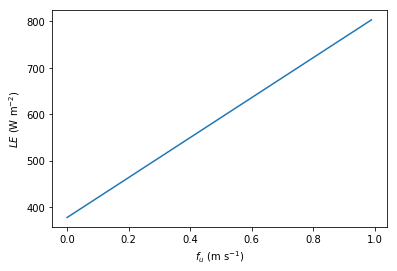

In [50]:
plot_expr(eq_16.rhs.subs({Delta_eTa: eq_Delta_eTa.rhs}).subs(vdict).subs({T_a: 300}), f_u, LE, 1e-6, 1, clf=True)

With a $f_u$ value of 0.2 m/s, we would get close to the 475 W/m2 of the PT equation.

In [51]:
vdict[f_u] = 0.2
eq_16.rhs.subs({Delta_eTa: eq_Delta_eTa.rhs}).subs(vdict).subs({T_a: 300})

463.516620292175

## Plots of multiple functions

In [52]:
def plot_expr2(xvar, ylvar, xmin, xmax, yldata, yrdata=[],
               yrvar=None, clf=True, npoints=100):
    '''
    Plot expression as function for variable from xmin to xmax.
    Example:
    vdict = cdict.copy()
    vdict[G] = 0
    vdict[R] = 500
    vdict[P_a] = 101325
    vdict[alpha_P] = 1.26
    vdict[gamma_P] = eq_gamma.rhs.subs(vdict)
    vdict[Delta_eTa] = eq_Delta_eTa.rhs.subs(vdict)
    vdict[e_a] = eq_ea.rhs.subs(vdict)
    vdict[e_d] = 0.5 * vdict[e_a]
    vdict[f_u] = 0.2
    expr1 = eq_16.rhs.subs(vdict)
    expr2 = eq_8P.rhs.subs(vdict)
    expr3 = vdict[Delta_eTa]
    xvar = T_a
    ylvar = LE
    xmin = 273.
    xmax = 320.
    lefty = [(expr1, 'eq_16'), (expr2, 'eq_8P')]
    righty = [(expr3, Delta_eTa.name)]
    plot_expr2(xvar, ylvar, xmin, xmax, lefty, yrdata=righty, yrvar = Delta_eTa)
    '''
    linestyles = ['-', '--', '-.', ':']
    if clf:
        plt.close
        plt.clf
    if hasattr(xvar, 'definition'): 
        xlabel = '$'+latex(xvar)+'$'+ ' (' + markdown(derive_unit(xvar)) + ')'
    else: 
        xlabel = xvar
    if hasattr(ylvar, 'definition'): 
        yllabel = '$'+latex(ylvar)+'$'+ ' (' + markdown(derive_unit(ylvar)) + ')'
    else: 
        yllabel = ylvar       
    
    xstep = (xmax - xmin)/npoints
    xvals = arange(xmin, xmax, xstep)
       
    fig, ax1 = plt.subplots()
    color = 'black'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(yllabel, color=color)
    i = 0
    for (expr1, y1var) in yldata:
        linestyle = linestyles[i]
        i= i + 1
        try: 
            y1vals = [expr1.subs(xvar, dummy).n() for dummy in xvals]                   
            ax1.plot(xvals, y1vals, color=color, linestyle=linestyle, label=y1var)
        except Exception as e1:
            print([expr1.subs(xvar, dummy) for dummy in xvals])
            print(e1)
        ax1.tick_params(axis='y', labelcolor=color)
    plt.legend()
    
    if yrdata:
        if hasattr(ylvar, 'definition'): 
            yrlabel = '$'+latex(yrvar)+'$'+ ' (' + markdown(derive_unit(yrvar)) + ')'
        else: 
            yrlabel = yrvar       
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel(yrlabel, color=color)
        i = 0
        
        for (expr2, y2var) in yrdata:
            linestyle = linestyles[i]
            i= i + 1
            try:
                y2vals = [expr2.subs(xvar, dummy).n() for dummy in xvals]
                ax2.plot(xvals, y2vals, color=color, linestyle=linestyle, label=y2var)
            except Exception as e1:
                print([expr2.subs(xvar, dummy).n() for dummy in xvals])
                print(e1)
            ax2.tick_params(axis='y', labelcolor=color)
            leg=ax2.legend(loc='lower right')
            ax2.add_artist(leg);

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

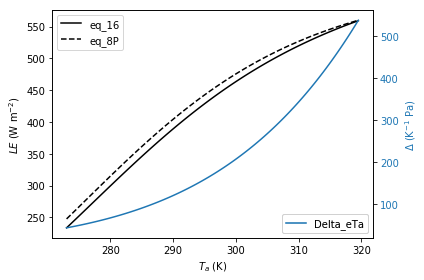

In [53]:
# Example
vdict = cdict.copy()
vdict[G] = 0
vdict[R] = 500
vdict[P_a] = 101325
vdict[alpha_P] = 1.26
vdict[gamma_P] = eq_gamma.rhs.subs(vdict)
vdict[Delta_eTa] = eq_Delta_eTa.rhs.subs(vdict)
vdict[e_a] = eq_ea.rhs.subs(vdict)
vdict[e_d] = 0.5 * vdict[e_a]
vdict[f_u] = 0.2
expr1 = eq_16.rhs.subs(vdict)
expr2 = eq_8P.rhs.subs(vdict)
expr3 = vdict[Delta_eTa]
xvar = T_a
ylvar = LE
xmin = 273.
xmax = 320.
lefty = [(expr1, 'eq_16'), (expr2, 'eq_8P')]
righty = [(expr3, Delta_eTa.name)]
plot_expr2(xvar, ylvar, xmin, xmax, lefty, yrdata=righty, yrvar = Delta_eTa)

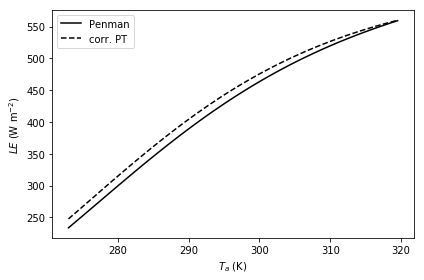

In [54]:
vdict = cdict.copy()
vdict[G] = 0
vdict[R] = 500
vdict[P_a] = 101325
vdict[alpha_P] = 1.26
vdict[f_u] = 0.2
vdict[e_a] = eq_ea.rhs.subs(vdict)
vdict[e_d] = 0.5 * vdict[e_a]
vdict[gamma_P] = eq_gamma.rhs.subs(vdict)
vdict[Delta_eTa] = eq_Delta_eTa.rhs.subs(vdict)
expr1 = eq_16.rhs.subs(vdict)
expr2 = eq_8P.rhs.subs(vdict)
xvar = T_a
ylvar = LE
xmin = 273.
xmax = 320.
lefty = [(expr1, 'Penman'), (expr2, 'corr. PT')]
plot_expr2(xvar, ylvar, xmin, xmax, lefty)

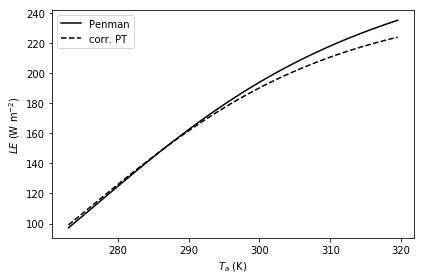

In [55]:
vdict = cdict.copy()
vdict[G] = 0
vdict[R] = 200
vdict[P_a] = 101325
vdict[alpha_P] = 1.26
vdict[gamma_P] = eq_gamma.rhs.subs(vdict)
vdict[Delta_eTa] = eq_Delta_eTa.rhs.subs(vdict)
vdict[e_a] = eq_ea.rhs.subs(vdict)
vdict[e_d] = 0.5 * vdict[e_a]
vdict[f_u] = 0.1
expr1 = eq_16.rhs.subs(vdict)
expr2 = eq_8P.rhs.subs(vdict)
xvar = T_a
ylvar = LE
xmin = 273.
xmax = 320.
lefty = [(expr1, 'Penman'), (expr2, 'corr. PT')]
plot_expr2(xvar, ylvar, xmin, xmax, lefty)

**The temperature sensitivies of the PT-equation and the PM equation at constant $f_u$ and relative humidity are different, and to get as close as possible to the PT equation, the value of $f_u$ needs to be adjusted to the radiation level.**

# Literature

Monteith, J. L. and Unsworth, M. H.: Principles of environmental physics: plants, animals, and the atmosphere, 4th ed., Elsevier/Academic Press, Amsterdam ; Boston., 2013.

Penman, H. L.: Natural Evaporation from Open Water, Bare Soil and Grass, Proceedings of the Royal Society of London. Series A, Mathematical and Physical Sciences, 193(1032), 120–145, doi:10.1098/rspa.1948.0037, 1948.

Priestley, C. H. B. and Taylor, R. J.: On the Assessment of Surface Heat Flux and Evaporation Using Large-Scale Parameters, Monthly Weather Review, 100(2), 81–92, doi:10.1175/1520-0493(1972)100<0081:OTAOSH>2.3.CO;2, 1972.
